In [112]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData

## Sepia Example 1: multivariate-output with simulations and observations
In this example, we have synthetic data with:

- Number of simulations: 100
- Number of output points per simulation: 50
- Number of observed data: 10
- Number of output points per observation: 20
- One variable `x` known for both simulations and observations
- Nine variables `t` known only for simulations

First, we load the data (shapes for each shown in comments):

In [113]:
# Load synthetic data: replace with your own data
dat = scipy.io.loadmat('multi_sim_and_obs_data.mat')
y_sim = dat['y'].T                     # Simulation outputs, (100, 50)
y_ind_sim = dat['y_ind'].squeeze()     # Simulation output indices, (50, )
x_sim = dat['x_sim']                   # x sim input, (100, 1)
t_sim = dat['t_sim']                   # t sim input, (100, 9)
y_obs = dat['y_obs'].T                 # Observed outputs, (10, 20)
y_ind_obs = dat['y_ind_obs'].squeeze() # Observed output indices, (20, )
x_obs = dat['x_obs']                   # x obs input, (10, 1)

Next, we initialize the SepiaData object which does some basic checking about whether the input data
are of the correct shapes, and infers what kind of model you're going to use based on the input data.

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 50, obs y dimension 20
n  =    10 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     9 (number of additional simulation inputs to calibrate)
pu NOT SET (transformed response dimension); call method create_K_basis
pv NOT SET (transformed discrepancy dimension); call method create_D_basis



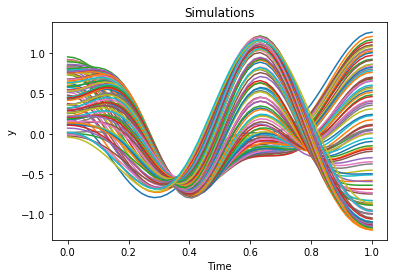

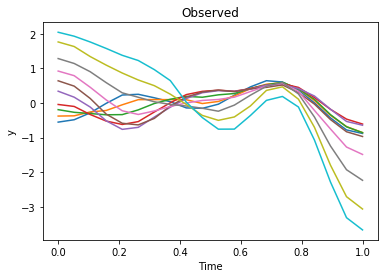

In [114]:
data = SepiaData(x_sim, t_sim, y_sim, y_ind_sim, x_obs, y_obs, y_ind_obs)
print(data)

plt.plot(data.sim_data.y_ind, data.sim_data.y.T)
plt.title('Simulations')
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

plt.plot(data.obs_data.y_ind, data.obs_data.y.T)
plt.title('Observed')
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

Next, we want to rescale the inputs `x` and `t` to the unit hypercube and standardize the `y` values.
These steps are important for ensuring the default prior values make sense.
We also create PCA and discrepancy basis elements.

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 50, obs y dimension 20
n  =    10 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     9 (number of additional simulation inputs to calibrate)
pu =     5 (transformed response dimension)
pv =     1 (transformed discrepancy dimension)



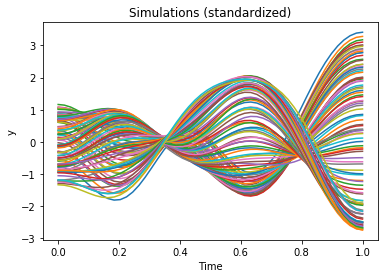

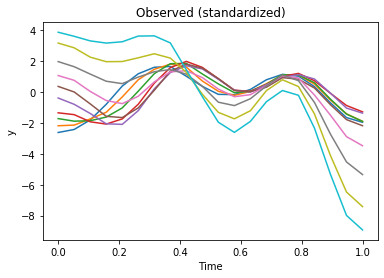

Text(0.5, 1.0, 'PCA basis')

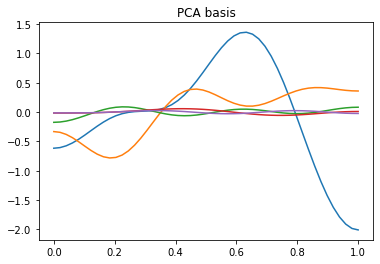

In [115]:
n_pc = 5
data.standardize_y()
data.transform_xt()
data.create_K_basis(n_pc)
data.create_D_basis('constant')
print(data)

plt.plot(data.sim_data.y_ind, data.sim_data.y_std.T)
plt.title('Simulations (standardized)')
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

plt.plot(data.obs_data.y_ind, data.obs_data.y_std.T)
plt.title('Observed (standardized)')
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

plt.plot(y_ind_sim, data.sim_data.K.T)
plt.title('PCA basis')

Next, we set up the model object; a lot of precalculation of important model components is done here.

In [116]:
model = setup_model(data)


lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.


Finally, we are ready to do MCMC.



In [117]:
n_mcmc = 100
np.random.seed(42)
model.do_mcmc(n_mcmc)



100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


Here is a basic visualization of the MCMC results: histograms of the MCMC samples.

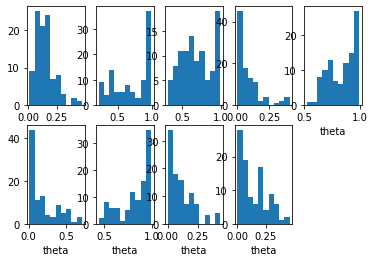

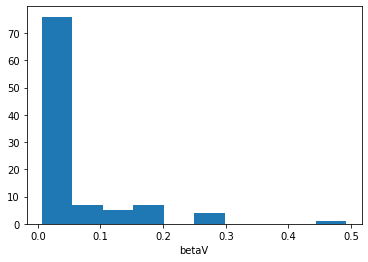

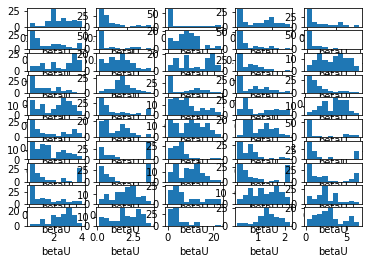

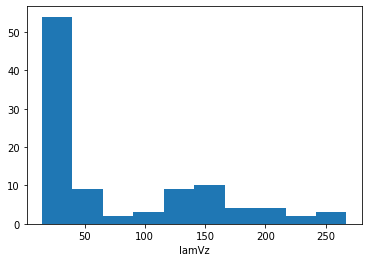

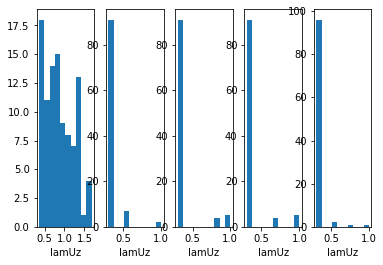

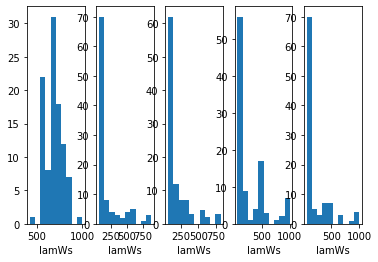

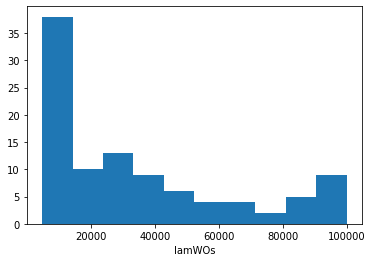

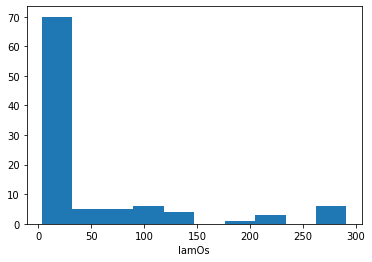

In [118]:
samples_dict = {p.name: p.mcmc_to_array() for p in model.params.mcmcList}

for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.hist(samples_dict[k][:, j])
        plt.xlabel(k)
    plt.show()
    

Trace plots of the MCMC samples. (These don't look good, by the way!)

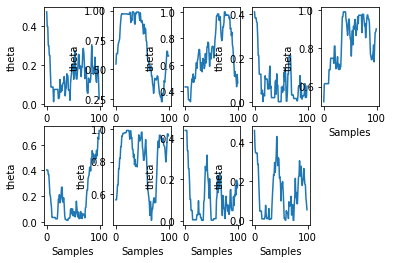

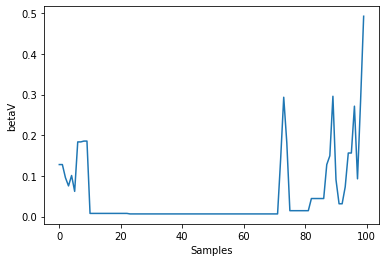

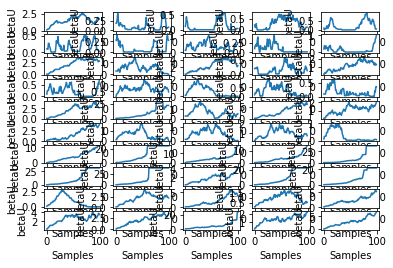

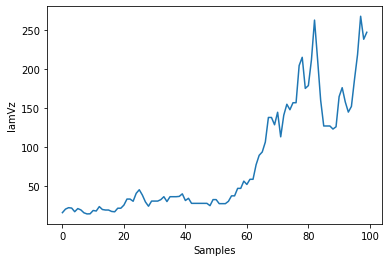

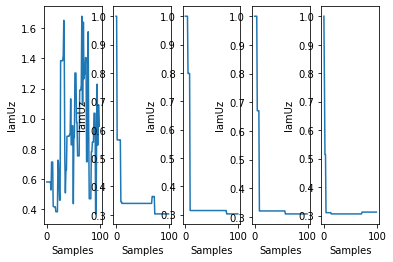

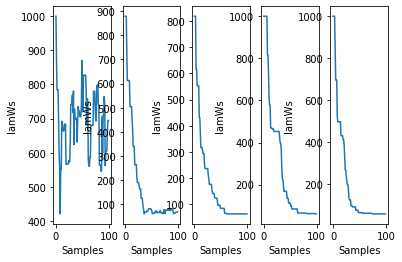

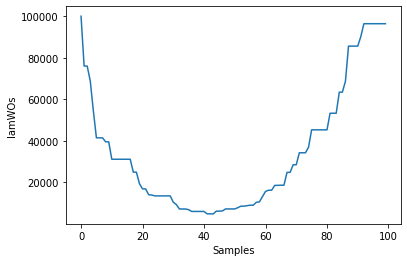

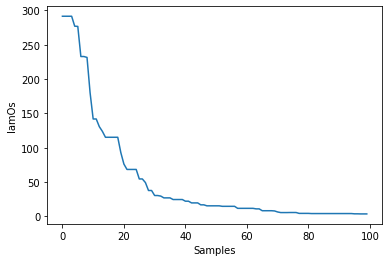

In [119]:
for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.plot(samples_dict[k][:, j])
        plt.xlabel('Samples')
        plt.ylabel(k)
    plt.show()

